In [21]:
import warnings
import logging

logging.getLogger("urllib3").setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore", message=".*NotOpenSSLWarning.*")
warnings.filterwarnings("ignore") # Suppress warnings globally


### Setup

In [29]:
# Import necessary libraries
import os
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import torchvision.transforms as transforms

warnings.filterwarnings("ignore", category=Warning)

%matplotlib inline

In [30]:
# Step 1: Load and Normalize CIFAR-10 Dataset
# CIFAR-10 is a small image classification dataset with 10 classes (e.g., "plane", "car", etc.)
batch_size = 1000
n_epochs = 15
dropout_rate = 0.0 # for training

# Define transformations for normalization and converting to float32
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load train and test sets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# Access the class labels
class_labels = trainset.classes

# Create DataLoader for batch processing
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [31]:
# Step 2: Define LeNet Model Variants (Standard, Dropout, MC Dropout)
class LeNetMCDropout(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(LeNetMCDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 192, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(192, 192, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(192 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=dropout_rate)  # Dropout layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 192 * 8 * 8)
        x = F.relu(self.fc1(self.dropout(x)))
        x = F.relu(self.fc2(self.dropout(x)))
        x = self.fc3(self.dropout(x))
        return F.softmax(x, dim=1)  # Use softmax for probabilities

# Step 3: Define Training and Evaluation Functions
def train_model(model, trainloader, num_epochs=10, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    model.train()
    print("Training Model...")

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs = inputs.to(device, dtype=torch.float32)  # Ensure correct dtype
            labels = labels.to(device, dtype=torch.long)     # Move labels to MPS (and long type)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}")
    return model

In [32]:

def evaluate_model(model, testloader, num_classes=10, print_results=True):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in testloader:
            # Move inputs and labels to the same device and correct data types
            inputs = inputs.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            all_preds.extend(predicted.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())   # Collect ground truth

    # Overall accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    # Per-class accuracy
    report = classification_report(all_labels, all_preds, labels=range(num_classes), output_dict=True)

    if print_results:
        print(f"Overall Test Accuracy: {accuracy * 100:.2f}%")
        for i in range(num_classes):
            print(f"Accuracy for class {i}: {report[str(i)]['precision'] * 100:.2f}%")

    return accuracy, report

# Step 4: Monte Carlo Dropout Evaluation
def mc_dropout_evaluation(model, testloader, num_classes=10, num_samples=10, print_results=True):
    model.train()  # Keep dropout layers active for MC Dropout
    all_mean_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient computations
        for inputs, labels in testloader:
            # Move inputs and labels to the same device and correct data types
            inputs = inputs.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)
            
            mc_preds = []
            for _ in range(num_samples):
                outputs = model(inputs)
                mc_preds.append(outputs.cpu().numpy())  # Collect predictions
            
            # Average predictions over the multiple stochastic forward passes
            mc_preds = np.mean(mc_preds, axis=0)
            all_mean_preds.append(mc_preds)
            all_labels.extend(labels.cpu().numpy())

    # Combine all predictions
    all_mean_preds = np.vstack(all_mean_preds)  # Shape: (num_samples, num_classes)
    all_labels = np.array(all_labels)
    predicted_classes = np.argmax(all_mean_preds, axis=1)  # Get the final predicted class

    # Overall accuracy
    accuracy = accuracy_score(all_labels, predicted_classes)
    # Per-class accuracy
    report = classification_report(all_labels, predicted_classes, labels=range(num_classes), output_dict=True)

    if print_results:
        print(f"MC Dropout Overall Test Accuracy: {accuracy * 100:.2f}%")
        # Per-class accuracy
        for i in range(num_classes):
            print(f"MC Dropout Accuracy for class {i}: {report[str(i)]['precision'] * 100:.2f}%")

    return accuracy, report

In [33]:
# Initialize device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Create the model and load saved weights  
model = LeNetMCDropout(dropout_rate=dropout_rate).to(device, dtype=torch.float32)
if os.path.exists(f"data/models/model_b{batch_size}_e{n_epochs}.pth"):
    model.load_state_dict(torch.load(f"data/models/model_b{batch_size}_e{n_epochs}_d.pth"))
    print(f"Using model model_b{batch_size}_e{n_epochs}")
else:
    print("Using untrained model")

Using device: mps


FileNotFoundError: [Errno 2] No such file or directory: 'data/models/model_b1000_e15_d.pth'

### Train

In [6]:
# Step 5: Train and Evaluate

# Train the model
model = train_model(model, trainloader, num_epochs=n_epochs)
# Save the model
save_path = f"data/models/model_b{batch_size}_e{n_epochs}_d{str(dropout_rate)[-1]}.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Training Model...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [1/30], Loss: 2.1096


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [2/30], Loss: 2.0357


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [3/30], Loss: 2.0107


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [4/30], Loss: 1.9939


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [5/30], Loss: 1.9971


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [6/30], Loss: 2.0151


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [7/30], Loss: 2.0353


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [8/30], Loss: 2.0706


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [9/30], Loss: 2.0727


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [10/30], Loss: 2.0886


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [11/30], Loss: 2.0690


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [12/30], Loss: 2.1454


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [13/30], Loss: 2.1001


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [14/30], Loss: 2.1212


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [15/30], Loss: 2.1968


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [16/30], Loss: 2.1500


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [17/30], Loss: 2.1932


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [18/30], Loss: 2.2408


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [19/30], Loss: 2.1676


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [20/30], Loss: 2.1697


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [21/30], Loss: 2.1966


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [22/30], Loss: 2.2125


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [23/30], Loss: 2.3000


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [24/30], Loss: 2.3334


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [25/30], Loss: 2.3326


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [26/30], Loss: 2.3219


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [27/30], Loss: 2.3158


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [28/30], Loss: 2.3072


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [29/30], Loss: 2.3017


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch [30/30], Loss: 2.3044
Model saved to data/models/model_b128_e30_d0.pth


### Evaluate

In [34]:
# Define dropout rates
dropout_rates = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 0.95]

#### Fixed dropout

In [35]:
# Evaluate the model with and without MC Dropout
print("\nStandard Evaluation:")
evaluate_model(model, testloader)

print("\nMC Dropout Evaluation:")
mc_dropout_evaluation(model, testloader);


Standard Evaluation:


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Overall Test Accuracy: 10.61%
Accuracy for class 0: 0.00%
Accuracy for class 1: 0.00%
Accuracy for class 2: 0.00%
Accuracy for class 3: 0.00%
Accuracy for class 4: 0.00%
Accuracy for class 5: 18.73%
Accuracy for class 6: 0.00%
Accuracy for class 7: 31.03%
Accuracy for class 8: 10.27%
Accuracy for class 9: 0.00%

MC Dropout Evaluation:


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


MC Dropout Overall Test Accuracy: 10.61%
MC Dropout Accuracy for class 0: 0.00%
MC Dropout Accuracy for class 1: 0.00%
MC Dropout Accuracy for class 2: 0.00%
MC Dropout Accuracy for class 3: 0.00%
MC Dropout Accuracy for class 4: 0.00%
MC Dropout Accuracy for class 5: 18.73%
MC Dropout Accuracy for class 6: 0.00%
MC Dropout Accuracy for class 7: 31.03%
MC Dropout Accuracy for class 8: 10.27%
MC Dropout Accuracy for class 9: 0.00%


#### Varying dropout with Confidence Intervals (CI)

In [36]:
# Evaluate model with varying dropout rates, including confidence intervals
def evaluate_with_varying_dropout(model, testloader, dropout_rates, num_samples=10, num_classes=10):
    results = []

    for rate in dropout_rates:
        print(f"\nEvaluating with Dropout Rate: {rate}")
        model.dropout.p = rate  # Dynamically set the dropout rate

        # Standard evaluation (dropout disabled)
        print("Standard Evaluation...")
        standard_accuracy, standard_report = evaluate_model(model, testloader, num_classes=num_classes, print_results=False)

        # MC Dropout evaluation (dropout enabled)
        print("MC Dropout Evaluation...")
        mc_accuracies = []  # Store accuracies for each MC sample
        for _ in range(num_samples):  # Multiple stochastic forward passes
            mc_accuracy, _ = mc_dropout_evaluation(model, testloader, num_classes=num_classes, num_samples=1, print_results=False)
            mc_accuracies.append(mc_accuracy)

        # Calculate mean accuracy and confidence interval for MC Dropout
        mc_mean_accuracy = np.mean(mc_accuracies)
        mc_std_dev = np.std(mc_accuracies)
        mc_ci = 1.96 * (mc_std_dev / np.sqrt(num_samples))  # 95% confidence interval

        # Store results
        results.append({
            "dropout_rate": rate,
            "standard_accuracy": standard_accuracy,
            "mc_mean_accuracy": mc_mean_accuracy,
            "mc_ci_lower": mc_mean_accuracy - mc_ci,
            "mc_ci_upper": mc_mean_accuracy + mc_ci,
            "per_class_standard": standard_report,
        })

    return results


Evaluating with Dropout Rate: 0.0
Standard Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


MC Dropout Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/V


Evaluating with Dropout Rate: 0.2
Standard Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


MC Dropout Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/V


Evaluating with Dropout Rate: 0.4
Standard Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


MC Dropout Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/V


Evaluating with Dropout Rate: 0.5
Standard Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


MC Dropout Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/V


Evaluating with Dropout Rate: 0.6
Standard Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


MC Dropout Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/V


Evaluating with Dropout Rate: 0.8
Standard Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


MC Dropout Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/V


Evaluating with Dropout Rate: 0.95
Standard Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


MC Dropout Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/V

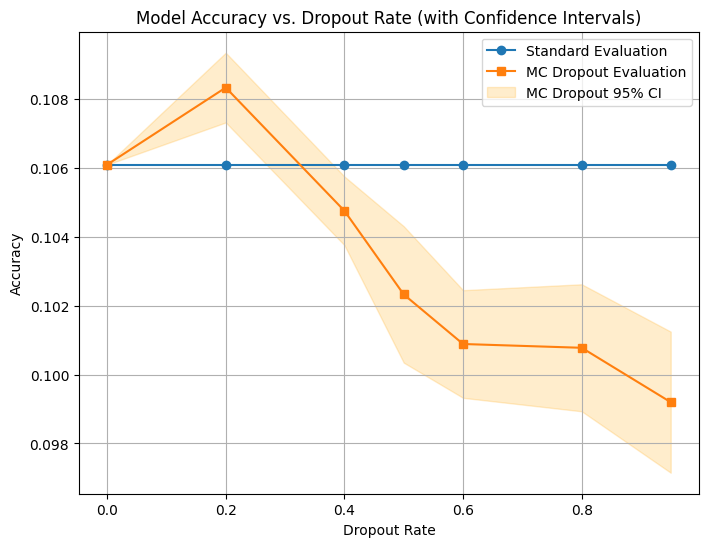

In [37]:
# Evaluate model with varying dropout rates
results = evaluate_with_varying_dropout(model, testloader, dropout_rates, num_samples=10, num_classes=10)

# Extract results
dropout_rates = [r["dropout_rate"] for r in results]
standard_accuracies = [r["standard_accuracy"] for r in results]
mc_mean_accuracies = [r["mc_mean_accuracy"] for r in results]
mc_ci_lowers = [r["mc_ci_lower"] for r in results]
mc_ci_uppers = [r["mc_ci_upper"] for r in results]

# Plot results with confidence intervals
plt.figure(figsize=(8, 6))
plt.plot(dropout_rates, standard_accuracies, label="Standard Evaluation", marker='o')
plt.plot(dropout_rates, mc_mean_accuracies, label="MC Dropout Evaluation", marker='s')
plt.fill_between(
    dropout_rates,
    mc_ci_lowers,
    mc_ci_uppers,
    color="orange",
    alpha=0.2,
    label="MC Dropout 95% CI"
)
plt.xlabel("Dropout Rate")
plt.ylabel("Accuracy")
plt.title("Model Accuracy vs. Dropout Rate (with Confidence Intervals)")
plt.legend()
plt.grid()
plt.show()

#### Varying dropout per class

In [38]:
import matplotlib.pyplot as plt

# Evaluate model with varying dropout rates
def evaluate_with_varying_dropout_per_class(model, testloader, dropout_rates, num_samples=10, num_classes=10):
    results = []

    for rate in dropout_rates:
        print(f"\nEvaluating with Dropout Rate: {rate}")
        model.dropout.p = rate  # Dynamically set the dropout rate

        # Standard evaluation (dropout disabled)
        print("Standard Evaluation...")
        standard_accuracy, standard_report = evaluate_model(model, testloader, num_classes=num_classes, print_results=False)

        # MC Dropout evaluation (dropout enabled)
        print("MC Dropout Evaluation...")
        mc_accuracy, mc_report = mc_dropout_evaluation(model, testloader, num_classes=num_classes, num_samples=num_samples, print_results=False)

        # Store results
        results.append({
            "dropout_rate": rate,
            "standard_accuracy": standard_accuracy,
            "mc_accuracy": mc_accuracy,
            "per_class_standard": standard_report,
            "per_class_mc": mc_report
        })

    return results


Evaluating with Dropout Rate: 0.0
Standard Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


MC Dropout Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



Evaluating with Dropout Rate: 0.2
Standard Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


MC Dropout Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



Evaluating with Dropout Rate: 0.4
Standard Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


MC Dropout Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



Evaluating with Dropout Rate: 0.5
Standard Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


MC Dropout Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



Evaluating with Dropout Rate: 0.6
Standard Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


MC Dropout Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



Evaluating with Dropout Rate: 0.8
Standard Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


MC Dropout Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



Evaluating with Dropout Rate: 0.95
Standard Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


MC Dropout Evaluation...


/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jlederer/Documents/UNI/Vorlesungen/Computer Science/CIDL/Repos/MC/MC-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


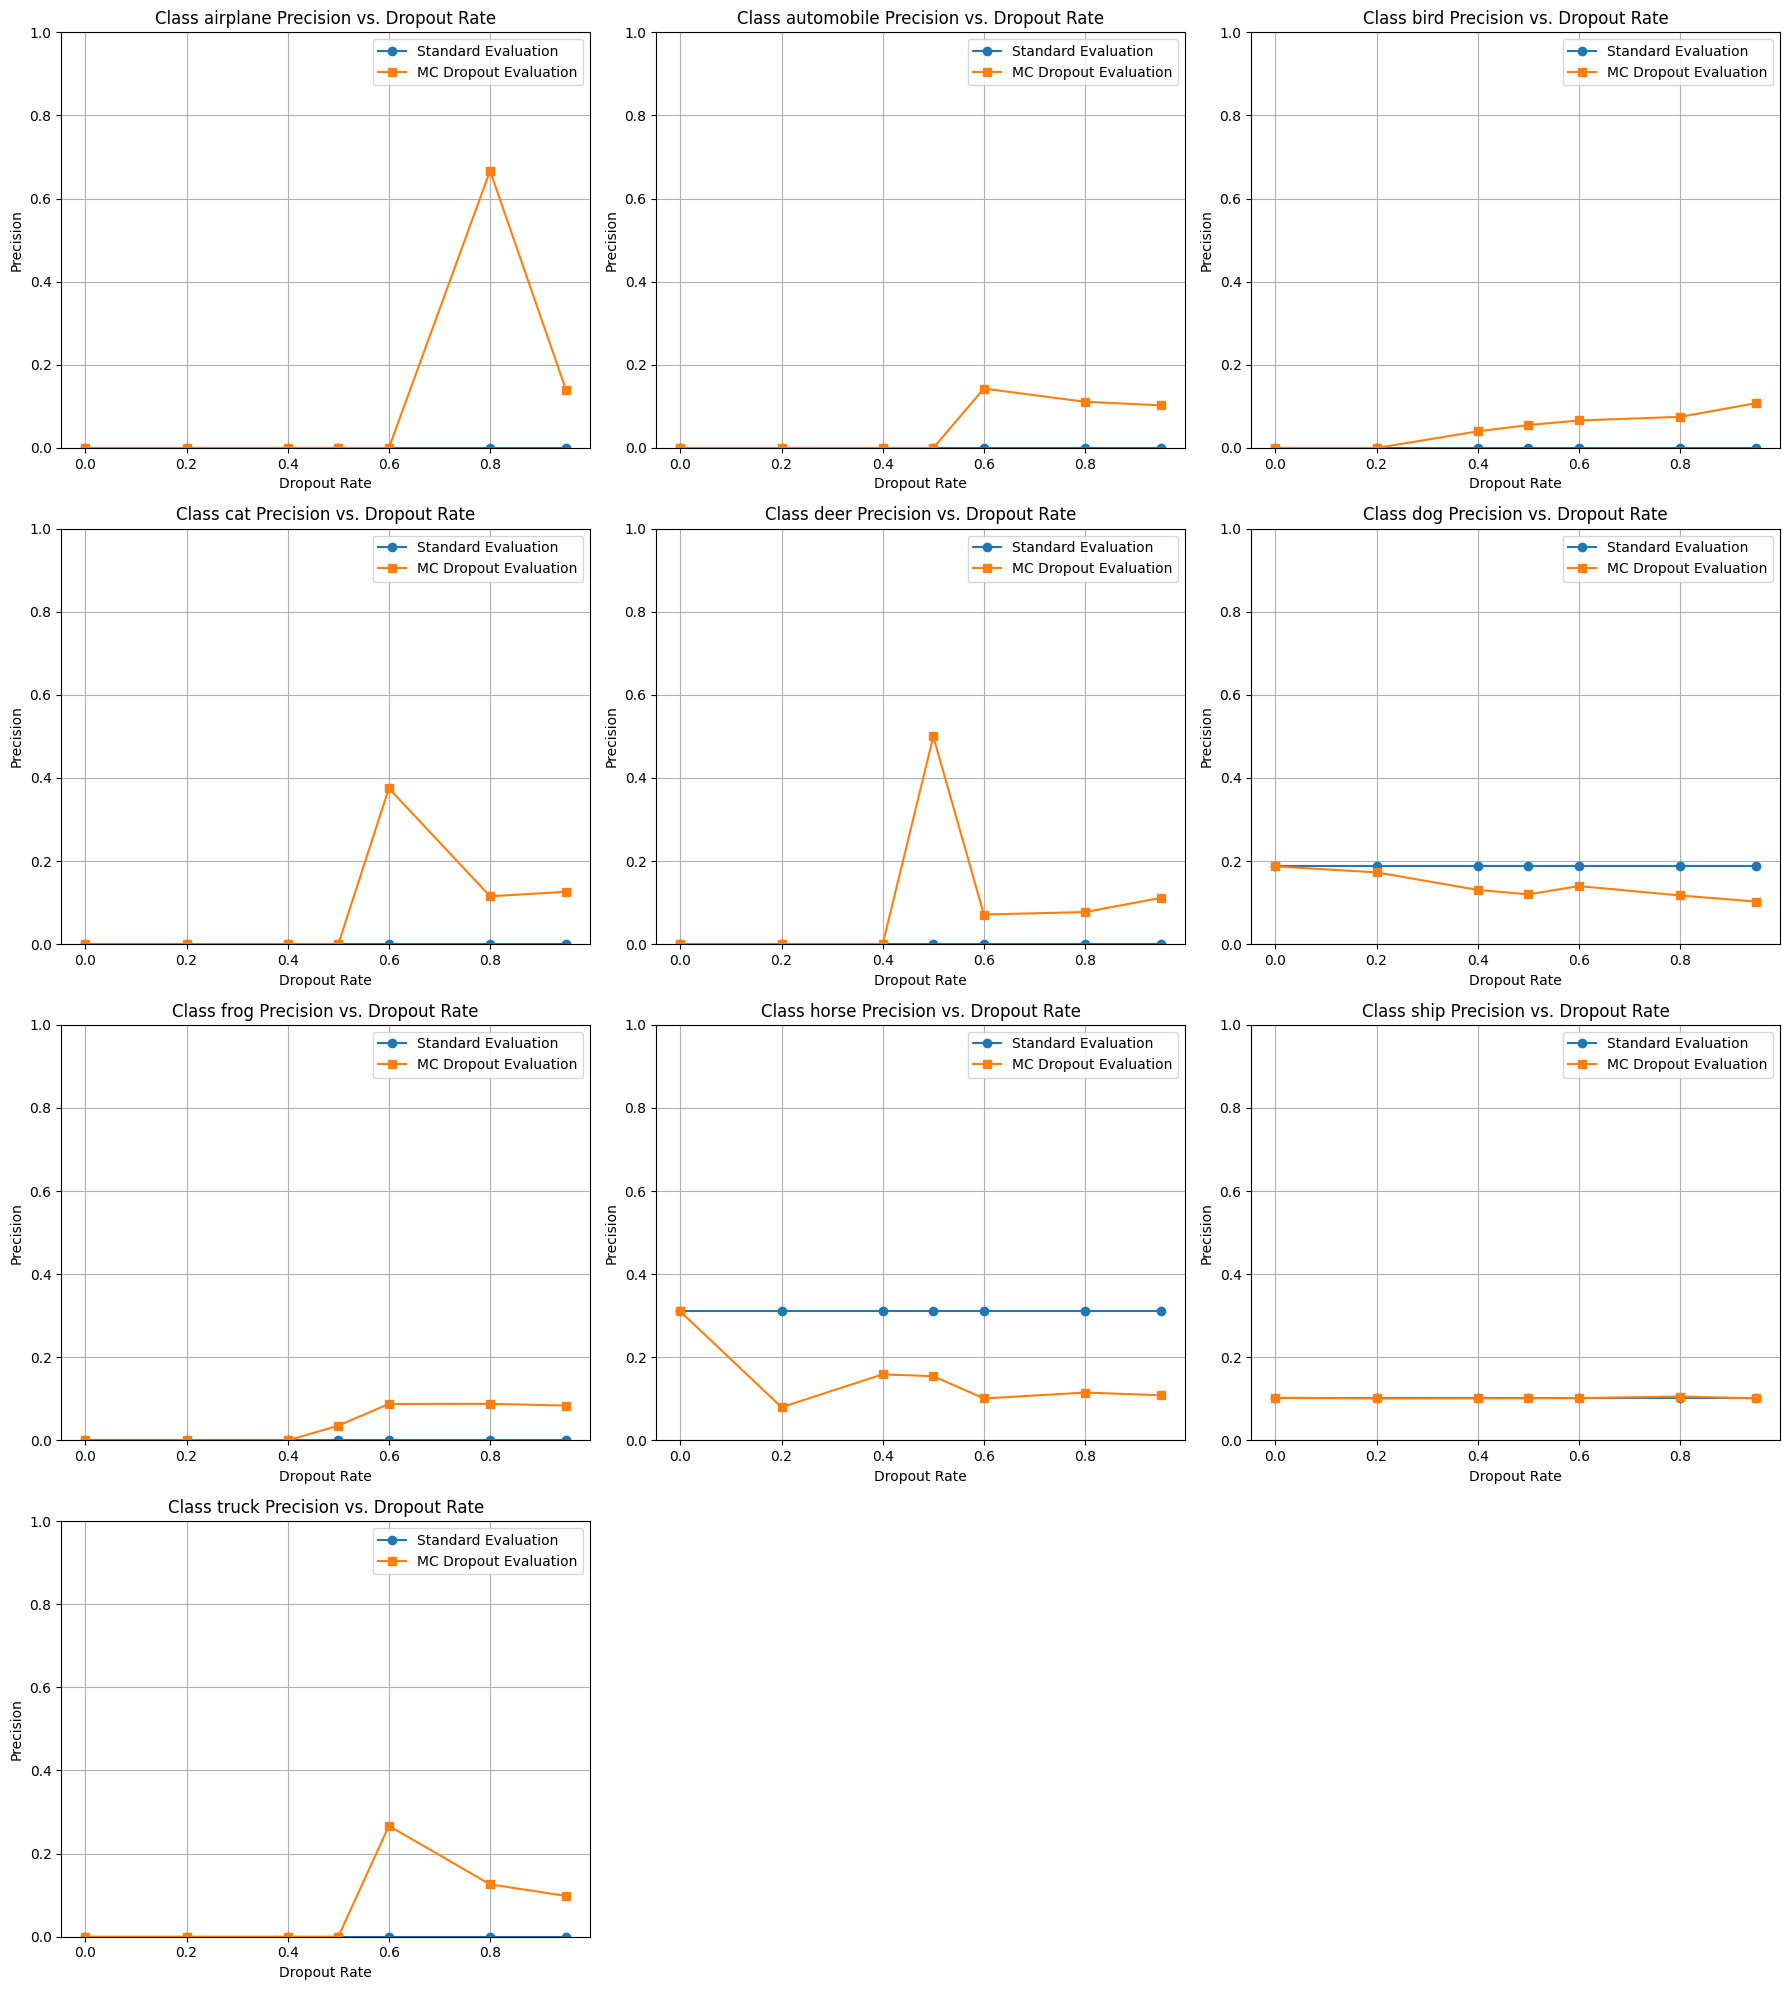

In [39]:
def plot_per_class_metric(results, metric='precision', num_classes=10):
    """
    Plot a specified metric (e.g., precision, recall, f1-score) per class for varying dropout rates using subplots.
    
    Args:
        results: List of dictionaries containing evaluation results.
        metric: The metric to plot (e.g., 'precision', 'recall', 'f1-score').
        num_classes: The number of classes to plot.
    """
    dropout_rates = [r["dropout_rate"] for r in results]
    rows, cols = (num_classes + 2) // 3, 3  # Arrange plots in a grid of 3 columns
    fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))

    for class_idx in range(num_classes):
        row, col = divmod(class_idx, cols)
        ax = axes[row, col]
        ax.set_ylim(0, 1)

        # Extract metrics
        standard_metrics = [
            r["per_class_standard"][str(class_idx)][metric] for r in results
        ]
        # Ensure 'per_class_mc' exists
        if all("per_class_mc" in r and str(class_idx) in r["per_class_mc"] for r in results):
            mc_metrics = [
                r["per_class_mc"][str(class_idx)][metric] for r in results
            ]
        else:
            mc_metrics = [None for _ in results]

        # Plot the metrics for the current class
        ax.plot(dropout_rates, standard_metrics, label="Standard Evaluation", marker='o')
        ax.plot(dropout_rates, mc_metrics, label="MC Dropout Evaluation", marker='s')
        ax.set_xlabel("Dropout Rate")
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f"Class {class_labels[class_idx]} {metric.capitalize()} vs. Dropout Rate")
        ax.legend()
        ax.grid()

    # Remove unused subplots
    for class_idx in range(num_classes, rows * cols):
        row, col = divmod(class_idx, cols)
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()


results = evaluate_with_varying_dropout_per_class(model, testloader, dropout_rates, num_samples=10, num_classes=10)
# Call the function to plot the precision for each class
plot_per_class_metric(results, metric='precision', num_classes=10)


# Fazit:
# 1. MC Dropout liefert uns nicht nur Vorhersagen, sondern auch Unsicherheiten für jedes Beispiel.
# 2. Datenpunkte mit hoher Standardabweichung sind jene, bei denen das Modell unsicher ist.
# 3. MC Dropout hilft, die Transparenz des Modells zu verbessern und kritische Entscheidungen sicherer zu machen.